# EuroSAT Data Pipeline Notebook  ```01_data_pipeline.ipynb```




* This google colab notebook demonstrates the complete data pipeline for EuroSAT Land Type Classification
* It uses the EuroSATDataPipeline class from src/data_pipeline.py


# Enviroment Setup & installation

Run these cells ONLY ONCE in a NEW Colab runtime

### Upload Kaggle Credentials

In [1]:
!pip install kaggle seaborn

In [2]:
from google.colab import files
import os

# Upload kaggle.json
print("upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle credentials configured")

upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle credentials configured


### Download and Extract Dataset

In [3]:
# Create folder structure
!mkdir -p data/raw data/interim data/processed src

# Download dataset from Kaggle
!kaggle datasets download -d apollo2506/eurosat-dataset -p data/raw/

# Extract dataset
!unzip -q data/raw/eurosat-dataset.zip -d data/raw/

# verifying what was extracted
if os.path.exists('data/raw'):
    raw_contents = os.listdir('data/raw')
    print(f"data/raw contents: {raw_contents}")

    # Check for EuroSAT folder
    if 'EuroSAT' in raw_contents:
        eurosat_contents = os.listdir('data/raw/EuroSAT')
        print(f"EuroSAT folder contents: {eurosat_contents}")
    else:
        print("EuroSAT folder not found - checking for other folders...")
        for item in raw_contents:
            item_path = f'data/raw/{item}'
            if os.path.isdir(item_path):
                print(f"Found directory: {item}")
                contents = os.listdir(item_path)
                print(f"  Contents: {contents[:5]}...")  # first 5 items

print("Dataset download and extraction complete")


Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
 99% 2.02G/2.04G [00:13<00:00, 258MB/s]
100% 2.04G/2.04G [00:13<00:00, 159MB/s]
data/raw contents: ['eurosat-dataset.zip', 'EuroSATallBands', 'EuroSAT']
EuroSAT folder contents: ['HerbaceousVegetation', 'Forest', 'Residential', 'test.csv', 'SeaLake', 'River', 'Highway', 'Industrial', 'PermanentCrop', 'AnnualCrop', 'validation.csv', 'label_map.json', 'Pasture', 'train.csv']
Dataset download and extraction complete


### Upload Data Pipeline Module ```data_pipeline.py```



In [4]:
print("upload data_pipeline.py :")
uploaded_files = files.upload()

# Move data_pipeline.py to src/
if 'data_pipeline.py' in uploaded_files:
    !mv data_pipeline.py src/
    print("data_pipeline.py moved to src/")
else:
    print("data_pipeline.py not found in uploaded files")


upload data_pipeline.py :


Saving data_pipeline.py to data_pipeline.py
data_pipeline.py moved to src/


### Import and Setup Pipeline

In [5]:
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Add src to Python path
sys.path.append('src')

try:
    from data_pipeline import EuroSATDataPipeline, load_processed_data, get_image_batch
    print("Successfully imported data pipeline modules")
except ImportError as e:
    print(f"Import error: {e}")
    print("Make sure data_pipeline.py is uploaded and in the src/ folder")

# Set up paths (Colab working directory)
RAW_DATA_DIR = "data/raw/EuroSAT"
PROCESSED_DATA_DIR = "data/processed"
INTERIM_DATA_DIR = "data/interim"

# Check current directory structure
print(f"Current working directory: {os.getcwd()}")
print(f"Raw data directory exists: {os.path.exists(RAW_DATA_DIR)}")


Successfully imported data pipeline modules
Current working directory: /content
Raw data directory exists: True


### Run Data Pipeline

🔧 Initializing Data Pipeline...
Pipeline initialized successfully
Starting EuroSAT Data Pipeline
Validating dataset structure...
AnnualCrop          :   3000 images
Forest              :   3000 images
HerbaceousVegetation:   3000 images
Highway             :   2500 images
Industrial          :   2500 images
Pasture             :   2000 images
PermanentCrop       :   2500 images
Residential         :   3000 images
River               :   2500 images
SeaLake             :   3000 images
Total images: 27000
Label map loaded from label_map.json
Label mapping:
   AnnualCrop          : 0
   Forest              : 1
   HerbaceousVegetation: 2
   Highway             : 3
   Industrial          : 4
   Pasture             : 5
   PermanentCrop       : 6
   Residential         : 7
   River               : 8
   SeaLake             : 9
\nCleaning CSV files...
\nProcessing train.csv...
Original shape: (18900, 4)
Removed index column: ['Unnamed: 0']
All images exist in dataset
Final shape: (18900, 4)
Sav

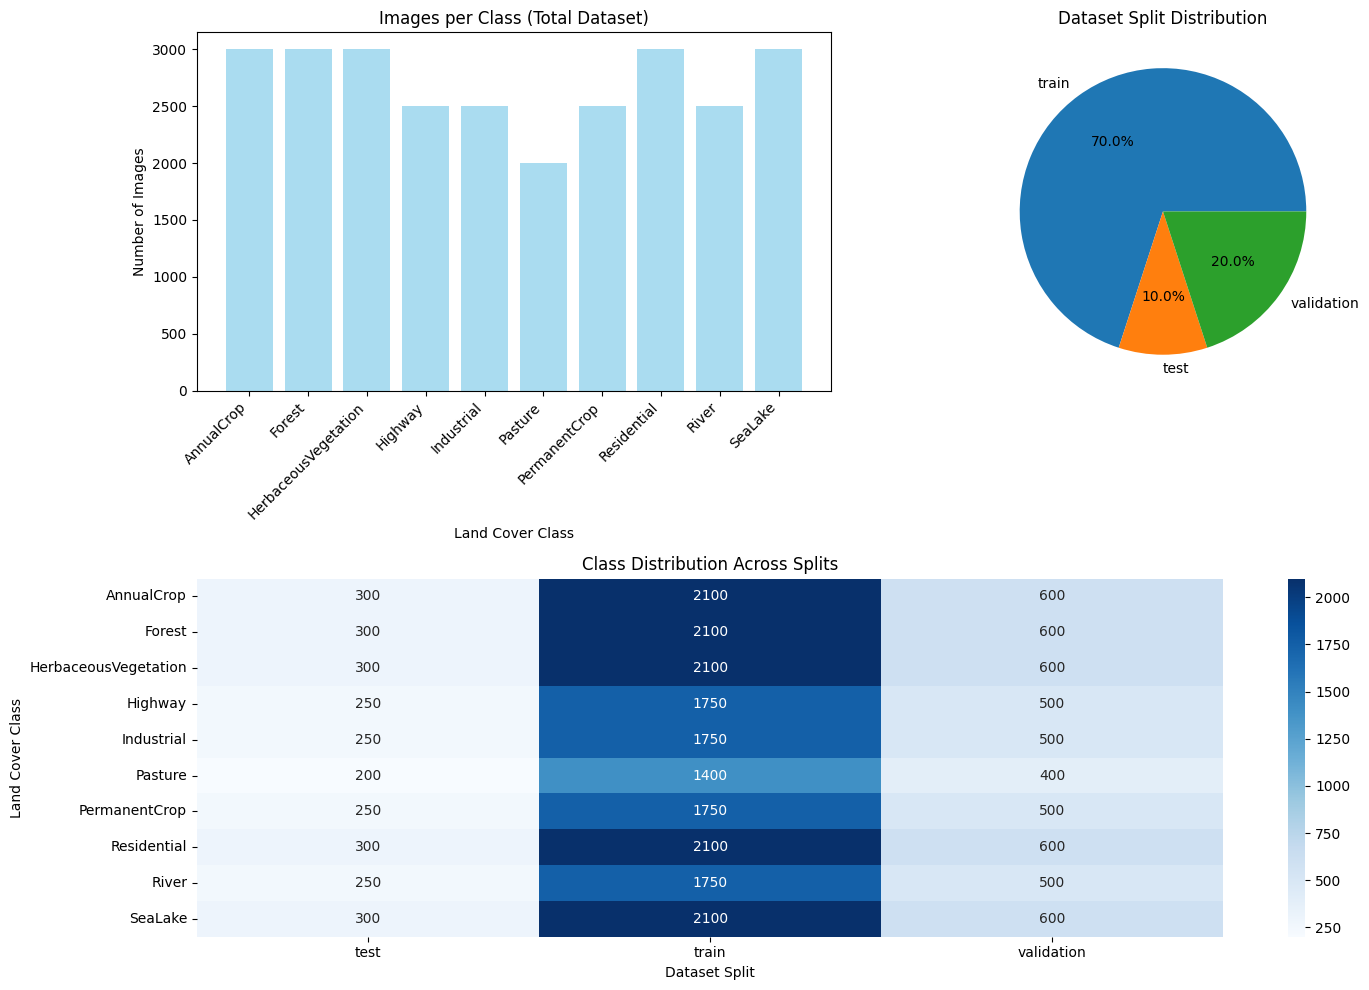

Statistics saved to data/processed
\nCreating sample visualization (2 per class)...


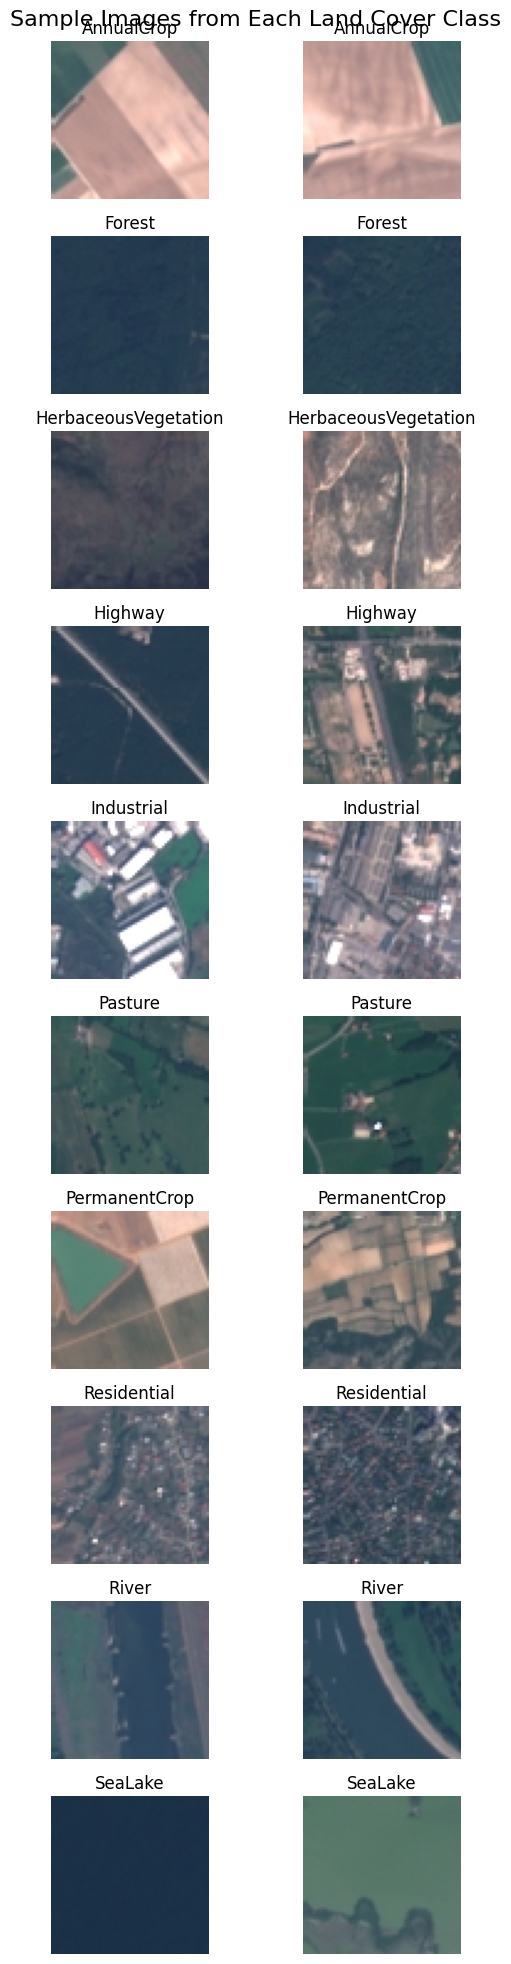

\n Data pipeline completed successfully
 Processed data saved to: data/processed
Pipeline completed successfully!


In [6]:
# Initialize the data pipeline
print("🔧 Initializing Data Pipeline...")
try:
    pipeline = EuroSATDataPipeline(
        raw_data_dir=RAW_DATA_DIR,
        processed_data_dir=PROCESSED_DATA_DIR,
        interim_data_dir=INTERIM_DATA_DIR
    )
    print("Pipeline initialized successfully")
except Exception as e:
    print(f"Pipeline initialization failed: {e}")
    pipeline = None

# Run the complete pipeline
if pipeline:
    try:
        cleaned_dfs = pipeline.run_complete_pipeline()
        print("Pipeline completed successfully!")
    except Exception as e:
        print(f"Pipeline failed: {str(e)}")
        import traceback
        traceback.print_exc()
        cleaned_dfs = {}
else:
    print("Cannot run pipeline - initialization failed")
    cleaned_dfs = {}

### Display Results

In [7]:
# Display results if pipeline succeeded
if cleaned_dfs:
    print("\nDataset Summary:")

    total_samples = sum(len(df) for df in cleaned_dfs.values())
    print(f"Total samples across all splits: {total_samples}")

    for split_name, df in cleaned_dfs.items():
        print(f"{split_name.capitalize():>12}: {len(df):>6} samples")

    # Display class distribution for training set
    if 'train' in cleaned_dfs:
        print(f"\nTraining Set Class Distribution:")
        train_df = cleaned_dfs['train']
        class_counts = train_df['class_name'].value_counts().sort_index()

        for class_name, count in class_counts.items():
            print(f"{class_name:>20}: {count:>4} samples")

    # Load and display statistics if available
    stats_file = Path(PROCESSED_DATA_DIR) / "dataset_statistics.json"
    if stats_file.exists():
        with open(stats_file, 'r') as f:
            stats = json.load(f)

        print(f"\nDataset Statistics:")
        print(f"Total classes: {stats['dataset_overview']['total_classes']}")
        print(f"Total images in raw dataset: {sum(stats['dataset_overview']['images_per_class'].values())}")


Dataset Summary:
Total samples across all splits: 27000
       Train:  18900 samples
        Test:   2700 samples
  Validation:   5400 samples

Training Set Class Distribution:
          AnnualCrop: 2100 samples
              Forest: 2100 samples
HerbaceousVegetation: 2100 samples
             Highway: 1750 samples
          Industrial: 1750 samples
             Pasture: 1400 samples
       PermanentCrop: 1750 samples
         Residential: 2100 samples
               River: 1750 samples
             SeaLake: 2100 samples

Dataset Statistics:
Total classes: 10
Total images in raw dataset: 27000


### Verify Generated Files

In [8]:
# Verify processed files
print(f"\nGenerated Files:")

processed_path = Path(PROCESSED_DATA_DIR)

expected_files = [
    "train.csv",
    "test.csv",
    "validation.csv",
    "dataset_statistics.json",
    "dataset_statistics.png",
    "sample_images.png",
    "label_map.json"
]

for file_name in expected_files:
    file_path = processed_path / file_name
    if file_path.exists():
        if file_name.endswith('.csv'):
            df = pd.read_csv(file_path)
            print(f"{file_name:<25} ({len(df)} rows)")
        else:
            print(f"{file_name}")
    else:
        print(f"{file_name:<25} (missing)")


Generated Files:
train.csv                 (18900 rows)
test.csv                  (2700 rows)
validation.csv            (5400 rows)
dataset_statistics.json
dataset_statistics.png
sample_images.png
label_map.json            (missing)


### Test Data Loading

In [9]:
try:
    # Test loading processed data
    loaded_dfs = load_processed_data(PROCESSED_DATA_DIR)
    print(f"Successfully loaded {len(loaded_dfs)} CSV files")

    # Test batch loading (if train data exists)
    if 'train' in loaded_dfs and len(loaded_dfs['train']) > 0:
        images, labels = get_image_batch(loaded_dfs['train'], batch_size=5)
        print(f"Successfully loaded image batch: {images.shape}")

except Exception as e:
    print(f"Data loading test failed: {str(e)}")

Successfully loaded 3 CSV files
Successfully loaded image batch: (5, 64, 64, 3)


### Final Summary

In [10]:
print(f"Processed data saved to: {PROCESSED_DATA_DIR}")
print("Next Steps:")
print("1. Download processed files using files.download() if needed")
print("2. Run 02_eda_visualization.ipynb for detailed data analysis")
print("3. Use the processed CSV files for model training")
print("4. Processed data is ready for PyTorch DataLoader")

# Optional: Download processed files
download_files = input("\nWould you like to download processed files? (y/n): ")
if download_files.lower() == 'y':
    for file_name in expected_files:
        file_path = processed_path / file_name
        if file_path.exists():
            try:
                files.download(str(file_path))
                print(f"Downloaded: {file_name}")
            except:
                print(f"Could not download: {file_name}")

Processed data saved to: data/processed
Next Steps:
1. Download processed files using files.download() if needed
2. Run 02_eda_visualization.ipynb for detailed data analysis
3. Use the processed CSV files for model training
4. Processed data is ready for PyTorch DataLoader

Would you like to download processed files? (y/n): y


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: train.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: test.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: validation.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: dataset_statistics.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: dataset_statistics.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: sample_images.png
